In [ ]:
!pip install pyunpack
!pip install patool

In [ ]:
import pyunpack
import os
os.system('apt-get install p7zip')

In [ ]:
for name in [
    'train',
    'songs',
    'members',
    'song_extra_info',
]:
    pyunpack.Archive(f"../input/{name}.csv.7z").extractall(f"../working/")

In [ ]:
# Load Python libraries
from sklearn import metrics, ensemble
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import warnings

In [ ]:
train = pd.read_csv('../working/train.csv')
songs = pd.read_csv('../working/songs.csv')
songs_extra = pd.read_csv('../working/song_extra_info.csv')
members = pd.read_csv('../working/members.csv', parse_dates=['registration_init_time','expiration_date'])

Добавим для пользователя количество дней, которое он зарегистрирован. Разделим на несколько категорий

In [ ]:
song_cols = ['song_id', 'artist_name', 'genre_ids', 'song_length', 'language']
train = train.merge(songs[song_cols], on='song_id', how='left')

members['registration_year'] = members['registration_init_time'].apply(lambda x: int(str(x)[0:4]))
members['expiration_year'] = members['expiration_date'].apply(lambda x: int(str(x)[0:4]))
members['membership_days'] = (members['expiration_date'] - members['registration_init_time']).dt.days.astype(int)
members['membership_days'] = members['membership_days'] // 200
members['membership_days'] = members['membership_days'].astype('category')

member_cols = ['msno','city','registered_via', 'registration_year', 'expiration_year', 'membership_days']
train = train.merge(members[member_cols], on='msno', how='left')

Часто направление музыки называют по годам: 90-е, 2010-е и т.д. Сделаем так же

In [ ]:
def isrc_to_year(isrc):
    if type(isrc) == str:
        return int(isrc[5:7]) // 5
    else:
        return np.nan

songs_extra['song_year'] = songs_extra['isrc'].apply(isrc_to_year)
songs_extra = songs_extra.drop(['isrc', 'name'], axis = 1)

In [ ]:
train = train.merge(songs_extra, on = 'song_id', how = 'left')

In [ ]:
train['genre_ids'] = train['genre_ids'].str.split('|').str[0]

In [ ]:
for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')

In [ ]:
train['song_year'] = train['song_year'].astype('category')

In [ ]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test = {
    'num_leaves': sp_randint(6, 50), 
    'min_child_samples': sp_randint(100, 500), 
    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'subsample': sp_uniform(loc=0.2, scale=0.8), 
    'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    train.drop(['target'],axis=1), 
    train['target'], 
    test_size=0.20, 
    random_state=42,
)

Тюним модель используя random search

In [ ]:
import lightgbm as lgb
fit_params = {
    "early_stopping_rounds":10, 
    "eval_metric" : 'auc', 
    "eval_set" : [(X_test, y_test)],
    'eval_names': ['valid'],
    'verbose': 100,
    'categorical_feature': 'auto',
}

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

clf = lgb.LGBMClassifier(max_depth=-1, random_state=42, silent=True, metric='None', n_jobs=-1, n_estimators=500)
gs = RandomizedSearchCV(
    estimator=clf, 
    param_distributions=param_test,
    n_iter=10,
    scoring='roc_auc',
    cv=5,
    refit=True,
    random_state=42,
    verbose=True
)

In [ ]:
gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

 Топ5 полученных результатов:
 
 Valid+-Std   :   Parameters
 
0.768+-0.000  :  
{'colsample_bytree': 0.6640914962437607, 'min_child_samples': 363, 'min_child_weight': 0.01, 'num_leaves': 19, 'reg_alpha': 0, 'reg_lambda': 5, 'subsample': 0.3457888702304499}

0.770+-0.001  :  
{'colsample_bytree': 0.9693313223519999, 'min_child_samples': 415, 'min_child_weight': 0.001, 'num_leaves': 14, 'reg_alpha': 5, 'reg_lambda': 0.1, 'subsample': 0.7473864212097256}

0.771+-0.000  :  
{'colsample_bytree': 0.9053708647569991, 'min_child_samples': 143, 'min_child_weight': 0.001, 'num_leaves': 15, 'reg_alpha': 2, 'reg_lambda': 20, 'subsample': 0.7818175966851368}

0.776+-0.001  :  
{'colsample_bytree': 0.4348501673009197, 'min_child_samples': 187, 'min_child_weight': 1, 'num_leaves': 41, 'reg_alpha': 50, 'reg_lambda': 100, 'subsample': 0.7207107783590823}

0.798+-0.000  :  
{'colsample_bytree': 0.8532168461905915, 'min_child_samples': 489, 'min_child_weight': 10.0, 'num_leaves': 47, 'reg_alpha': 2, 'reg_lambda': 20, 'subsample': 0.22505063396444688}

In [ ]:
best_params = {
    'colsample_bytree': 0.8532168461905915, 
    'min_child_samples': 489, 
    'min_child_weight': 10.0, 
    'num_leaves': 47, 
    'reg_alpha': 2, 
    'reg_lambda': 20, 
    'subsample': 0.22505063396444688,
}

Посчитаем среднее значение ROC AUC по каждому юзеру. Юзеров, которым нравится любая музыка, пропустим

In [ ]:
import lightgbm as lgb
from tqdm.auto import tqdm

from sklearn import model_selection
from sklearn import metrics

cv = model_selection.KFold(n_splits=5)


for train_ind, valid_ind in tqdm(cv.split(train), total_len=5): 
    X_train = train.drop(['target'],axis=1).loc[train_ind,:]
    y_train = train.loc[train_ind, 'target']
    
    X_valid = train.drop(['target'],axis=1).loc[valid_ind,:]
    y_valid = train.loc[valid_ind, 'target']
    
    clf = lgb.LGBMClassifier(
        max_depth=-1, 
        random_state=42, 
        silent=True, 
        metric='None', 
        n_jobs=-1, 
        n_estimators=500,
        **best_params,
    )
    clf.fit(X_train, y_train)
    pred = clf.predict_proba(X_valid)
    
    users = set(X_valid.msno)
    scores = []
    for i, user in enumerate(tqdm(users)):
        inds = (X_valid.msno == user)
        if len(np.unique(y_valid[inds])) < 2:
            continue
        scores.append(metrics.roc_auc_score(y_valid[inds], pred[inds, 1]))
    scores = np.array(scores)
    print(scores.mean(), np.median(scores))
    
#     lgbm_model = lgb.train(params, train_data, valid_sets=[val_data], )

 Ждать результатов достаточно долго, я запускал их на сервере, поэтому добавлю здесь только вывод, который получился:
 
 ROC AUC per user: 0.681254313312988
 
 
 Общее значение ROC AUC на кросс-валидации по 5 блокам: 0.798

#  Задание 2

In [40]:
from gensim.models import Word2Vec 
import random

In [52]:
pos_train = train[train.target == 1]
users_train = pos_train["msno"].unique().tolist()

In [53]:
pos_train.shape

(3714656, 16)

Оставим только строчки с позитивной реакцией. После этого сгенерируем предложения песен для юзера, и обучим на этом word2vec 

In [56]:
# list to capture purchase history of the customers
purchases_train = []

# populate the list with the product codes
for i in tqdm(users_train):
    temp = pos_train[pos_train["msno"] == i]["song_id"].tolist()
    purchases_train.append(temp)

  0%|          | 0/24401 [00:00<?, ?it/s]

In [57]:
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10,
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

In [58]:
model.build_vocab(purchases_train, progress_per=100)

In [59]:
model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(30845174, 33398500)

In [73]:
X = model.wv.vectors
X.shape

(52022, 100)

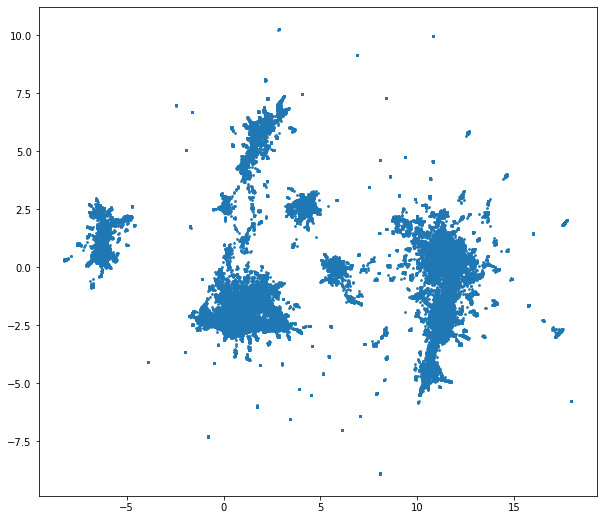

In [74]:
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

 На графике явно видны несколько групп кластеров песен

In [114]:
song_names = pos_train[["song_id", "artist_name"]]
song_names.drop_duplicates(inplace=True, subset='song_id', keep="last")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [118]:
song_names = user_artists.groupby('song_id')['artist_name'].apply(list).to_dict()

Так как у песен нет названия, то будем определять осмысленность similar используя artist_name для песни

In [133]:
def similar_products(v, n = 6):
    ms = model.wv.most_similar(v, topn= n+1)[1:]
    new_ms = []
    for j in ms:
        pair = (song_names[j[0]][0], j[1])
        new_ms.append(pair)
    return new_ms   

Посмотрим на выборку песен, попробуем для известных исполнителей найти их симилары

In [155]:
for ind in random.sample(list(range(1000)), 10):
    print(ind)
    print(list(song_names.values())[ind])
    print(list(song_names.keys())[ind])

971
['Andrea Bocelli']
+8TdbJ5Cv3vBihl4stlxoBv5Yse1t9vwdtgYOcxx8yE=
669
[]
+5DG/iKG7ess9E5E9ea+hEHP/BUdEoUGYO1cGAbfAj0=
992
['ONE OK ROCK']
+8jyGtpfbvV4T8sqlFP4XCL/JeuPkhLWaGbaUFEdds8=
937
[]
+871ymZ9Y/07ZfRvS/tSyR+bMrvKXkHTfpmjQnNreY8=
743
['李建復']
+5k2egs9bCz44gUW1ZQkF9xlPllzfWguFN2nGnZVWSA=
866
[]
+78a/6tnvOWrfJ645XoCLc4V/7QAPXtTBhATSl5ZmxM=
994
['陳翔']
+8kn+4j2ZiJ3VwCxUgu+/+v9psuoEhy2GZAtdwxeOBc=
944
['Sandaime J Soul Brothers from EXILE TRIBE (三代目 J Soul Brothers from EXILE TRIBE)']
+89xV4Ngw/wcDfs+MT8gLD4Z7+0pL/mq1TZy2b5LAGw=
643
["Children's Favorite's"]
+507l/Fl48TdV9JjmzwAcF3D6zms0FBURKYv++LFEWE=
160
['David Arnold']
+/eQ+RnO+weCVRUqD4FemhiSzByya7OwKwq1mCrn5OM=


Из известных мне здесь только 'Andrea Bocelli', поэтому найдем симилары к его песне

In [157]:
model.wv.key_to_index['+8TdbJ5Cv3vBihl4stlxoBv5Yse1t9vwdtgYOcxx8yE=']

28805

In [159]:
similar_products([X[28805], ], 20)

[('Andrea Bocelli', 0.8863276839256287),
 ('Andrea Bocelli', 0.8684341311454773),
 ('Andrea Bocelli', 0.8167124390602112),
 ('Andrea Bocelli', 0.8034621477127075),
 ('Andrea Bocelli', 0.7990178465843201),
 ('Andrea Bocelli', 0.7962299585342407),
 ('Andrea Bocelli', 0.7656412124633789),
 ('Andrea Bocelli', 0.7621732950210571),
 ('Dreaming', 0.7407352924346924),
 ('Andrea Bocelli', 0.7406356334686279),
 ('tico moon', 0.7349551916122437),
 ('何真真', 0.7297756671905518),
 ('滾石金韻民歌百大精選', 0.7293576002120972),
 ('Dreaming', 0.7211689949035645),
 ('傾聽心靈音樂', 0.7205897569656372),
 ('BeatleJazz', 0.7188231945037842),
 ('Christmas Crooners Collection', 0.7169662714004517),
 ('內田奈織', 0.7130300998687744),
 ('Lisa Ono (小野リサ)', 0.7116321325302124),
 ('純音樂', 0.71001797914505)]

Здесь понятным образом оказались другие песни Andrea Bocelli. Dreaming - это музыка для мечтания, что подходит. Tico Moon это какой-то японский ансамбль с арфой и гитарой. В принципе, похоже

Напишем функцию, которая будет определять понравится ли пользователю песня. Для этого посчитаем некоторую функцию для расстояний от выбранной песни до песен, которые нравятся юзеру и отдельно для песен, которые не нравится.

Казалось бы, что можно посчитать среднее расстояние (тогда метрика получается 0.65), но оказывается лучше считать максимальную похожесть (метрика 0.96). 

На самом деле это логично, потому что средняя похожесть полайканных песню на какую-то довольно странная величина. А вот если очень похожая песня с лайком, то, вероятно, и для новой песни будет лайк

In [238]:
def user_like(user, ask_song):
    if ask_song not in model.wv.key_to_index.keys():
        return 0
    pos_songs = train[(train.msno == user) & (train.target == 1)]['song_id']
    neg_songs = train[(train.msno == user) & (train.target == 0)]['song_id']
    
    ask_id = model.wv.key_to_index[ask_song]
    
    def find_mean_dist(songs):
        if len(songs) == 0:
            return 1
        dists = []
        for song in songs:
            try:
                cur_id = model.wv.key_to_index[song]
                dist = X[ask_id].dot(X[cur_id])
                dists.append(dist)
            except KeyError:
                continue
        return np.max(dists)
    
    pos_dist = find_mean_dist(pos_songs)
    neg_dist = find_mean_dist(neg_songs)
    
    return 1 if pos_dist > neg_dist else 0
            

In [242]:
small_train = train.sample(1000)

In [243]:
preds = []
for _, item in tqdm(small_train.iterrows(), total=len(small_train)):
    pred = user_like(item.msno, item.song_id)
    preds.append(pred)
preds = np.array(preds)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [244]:
metrics.roc_auc_score(small_train.target, preds)

0.9559586321721312